In [151]:
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import LeakyReLU, Dropout, Add, Concatenate

from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K

In [152]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [165]:
working_dir = 'drive/My Drive/DeepLearn/Fashion/'
df_label = pd.read_csv(working_dir + 'category_01.csv', index_col = 0)

def unite_categories(c1, c2, df_label):
    df_label[c1] = df_label[c1] + df_label[c2] - df_label[c1]*df_label[c2]
    df_label.drop(c2, axis = 1, inplace = True) 
    return df_label

#to_unite = [('blouse', 'T-shirt'), ('pants', 'jeans'), ('pants', 'legging'), ('socks', 'stocking')]
#for c1, c2 in to_unite:
#    df_label = unite_categories(c1, c2, df_label)

cat_names = np.array(df_label.columns)

TARGET_SIZE = (150, 100, 3)
TARGET_SHAPE = (TARGET_SIZE[1], TARGET_SIZE[0])
OUTPUT_CH = len(df_label.columns)

print(OUTPUT_CH)

df_label.columns

19


Index(['T-shirt', 'bag', 'belt', 'blazer', 'blouse', 'coat', 'dress', 'hat',
       'jeans', 'legging', 'pants', 'scarf', 'shoe', 'shorts', 'skirt',
       'socks', 'stocking', 'sunglass', 'sweater'],
      dtype='object')

31841.jpg bag coat hat legging scarf shoe


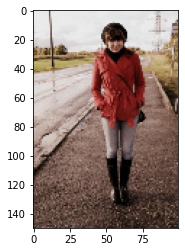

In [175]:
idi = np.random.choice(list(df_label.index))
img = cv2.imread(working_dir + "image/"+idi)
img = cv2.resize(img, TARGET_SHAPE)
plt.imshow(img[:,:,::-1])
labs = np.where(df_label.loc[idi]>0)
print(idi, " ".join(cat_names[labs]))

## Using Data Generator 
- to be able to augment data to prevent overfitting
- lower memory requirements

In [310]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df_label, folder = working_dir + "image/",
                 batch_size=64, n_channels=3, shuffle=True, target_size = TARGET_SIZE, aug = False):
        'Initialization'
        self.batch_size = batch_size
        
        self.folder = folder
        self.df_label = df_label
        
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.target_size = target_size
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
        
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.target_size[0], self.target_size[1], self.n_channels))
        Y = np.zeros((self.batch_size,OUTPUT_CH))
        
        # Computing images and augmenting
        for i, ID in enumerate(list_IDs_temp):
            filename = self.folder + ID
            img = cv2.imread(filename)
            img = cv2.resize(img, TARGET_SHAPE)
            #img = img[:,:,::-1]
            if self.aug:
                if random.random()>0.5:
                    img = tf.image.flip_left_right(img)
                    img = img.numpy()

                img = tf.image.random_hue(img, 0.04)
                img = tf.image.random_brightness(img, 0.1)
                img = tf.image.random_contrast(img, 0.9, 1.1)
                img = tf.image.random_saturation(img, 0.9, 1.1)
                img = img.numpy()
                img = tf.keras.preprocessing.image.random_shift(img, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
                
                img = tf.keras.preprocessing.image.random_rotation(img, 10, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')

            X[i,:,:,:] = img
            Y[i,:] =  np.array(df_label.loc[ID])
        return X, Y

# Model

In [218]:
base_model = tf.keras.applications.MobileNetV2(input_shape=TARGET_SIZE, include_top=False,weights="imagenet") 
#base_model = tf.keras.applications.VGG16(input_shape=TARGET_SIZE, include_top=False,weights="imagenet") 
#base_model = tf.keras.applications.ResNet50(
#    include_top=False, weights='imagenet', input_shape=TARGET_SIZE)
#base_model = tf.keras.applications.Xception(
#    include_top=False, weights='imagenet', input_shape=TARGET_SIZE)
base_model.summary()
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = False

names = []
for layer in base_model.layers:
    names.append(layer.name)
print(names)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 150, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 101, 3)  0           input_47[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 50, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [311]:
# Create the feature extraction model
#pre_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block_12_add').output)
out_names = {'resnet':['conv5_block3_out', 'conv4_block6_out', 'conv3_block4_out'],
             'xception':['block14_sepconv2_act', 'block12_sepconv3_act', 'block4_sepconv2_act', 'block3_sepconv2_act'],
             'mobnet':['out_relu', 'block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu']}

outputs = []
for name in out_names['mobnet']:
    outputs.append(base_model.get_layer(name).output)
pre_stack = tf.keras.Model(inputs=base_model.input,
                           outputs=outputs)
pre_stack.trainable = False

def get_model():
    inp = Input(TARGET_SIZE)
    x = tf.cast(inp, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    xs = pre_stack(x) #out #conv4_block6_out #conv3_block4_out

    x = xs[0]
    x = MaxPooling2D((1,4))(x)
    #x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x1 =  Dense(64, activation = 'relu', name = "pre_out_5")(x)

    x = xs[1]
    x = Conv2D(64, (3,3), name = "out_conv4", activation = 'relu',
              kernel_regularizer = tf.keras.regularizers.l2())(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x2 =  Dense(128, activation = 'relu', name = "pre_out_4")(x)

    x = xs[2]
    x = Conv2D(64, (3,3), name = "out_conv3_a", activation = 'relu',
               kernel_regularizer = tf.keras.regularizers.l2())(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3,3), name = "out_conv3_b", activation = 'relu',
               kernel_regularizer = tf.keras.regularizers.l2())(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x3 =  Dense(256, activation = 'relu', name = "pre_out_3")(x)

    x = xs[3]
    x = Conv2D(64, (3,3), name = "out_conv2_a", activation = 'relu',
               kernel_regularizer = tf.keras.regularizers.l2())(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3,3), name = "out_conv2_b", activation = 'relu',
               kernel_regularizer = tf.keras.regularizers.l2())(x)
    x = MaxPooling2D((2,6))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x4 =  Dense(128, activation = 'relu', name = "pre_out_2")(x)

    x = Concatenate()([x1, x2, x3, x4])
    x = Dense(64, activation = 'relu', name = "pre_out_a")(x)
    #x = Dense(64, activation = 'relu', name = "pre_out_b")(x)
    out = Dense(OUTPUT_CH, activation = 'sigmoid', name = "out")(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out) 
    return model

model = get_model()
model.summary()

Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 150, 100, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_32 (TensorF [(None, 150, 100, 3) 0           input_57[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Sub_32 (TensorFlowO [(None, 150, 100, 3) 0           tf_op_layer_RealDiv_32[0][0]     
__________________________________________________________________________________________________
model_78 (Model)                [(None, 5, 4, 1280), 2257984     tf_op_layer_Sub_32[0][0]         
___________________________________________________________________________________________

## Weighted loss

In [307]:
neg_weights = np.array(df_label.sum(axis = 0)/len(df_label))
pos_weights = 1 - neg_weights
print(pos_weights)
print(neg_weights)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0    
        epsilon = 1e-7
        loss += -K.mean(pos_weights*y_true*K.log(y_pred+epsilon)+neg_weights*(1-y_true)*K.log(1-y_pred+epsilon))
        return loss
    return weighted_loss

def soft_dice_loss(y_true, y_pred):
    gg = y_true*y_true
    pp = y_pred*y_pred
    pg = y_true*y_pred

    ll = 1-2*tf.reduce_sum(pg, axis = 1)/tf.reduce_sum(pp+gg, axis = 1)
    return tf.reduce_mean(ll)

[0.65809098 0.45488441 0.6935123  0.86800895 0.65137957 0.86726324
 0.74720358 0.86950037 0.92542878 0.91312453 0.9295302  0.92281879
 0.03020134 0.81282625 0.67076808 0.93661447 0.89261745 0.84153617
 0.90753169]
[0.34190902 0.54511559 0.3064877  0.13199105 0.34862043 0.13273676
 0.25279642 0.13049963 0.07457122 0.08687547 0.0704698  0.07718121
 0.96979866 0.18717375 0.32923192 0.06338553 0.10738255 0.15846383
 0.09246831]


# Train

In [312]:
from sklearn import model_selection

all_ids = list(df_label.index)
train_ids, test_ids = model_selection.train_test_split(all_ids, test_size = 0.1)

In [314]:
batch_size = 64
train_gen = DataGenerator(train_ids, df_label, batch_size = batch_size, aug = True)
test_gen = DataGenerator(test_ids, df_label, batch_size = batch_size, aug = False)
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape, np.min(x), np.max(x))

(64, 150, 100, 3) (64, 19) 0.0 255.0


In [323]:
model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = get_weighted_loss(pos_weights, neg_weights),
                #loss = 'binary_crossentropy',
              #loss = soft_dice_loss,
               metrics = ['binary_accuracy', tf.keras.metrics.AUC(multi_label=True)])
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor =0.2, patience = 5)]

In [324]:
EPOCHS = 5
model_history = model.fit(train_gen, epochs=EPOCHS,
                          validation_data=test_gen, validation_steps = len(test_ids)//batch_size,
                          callbacks = callbacks)

Epoch 1/5
37/37 [==============================] - 38s 1s/step - loss: 0.1650 - binary_accuracy: 0.8175 - auc_45: 0.7673 - val_loss: 0.1748 - val_binary_accuracy: 0.7364 - val_auc_45: 0.6988 - lr: 1.0000e-04
Epoch 2/5
37/37 [==============================] - 36s 972ms/step - loss: 0.1502 - binary_accuracy: 0.7708 - auc_45: 0.7803 - val_loss: 0.1679 - val_binary_accuracy: 0.7216 - val_auc_45: 0.7037 - lr: 1.0000e-04
Epoch 3/5
37/37 [==============================] - 36s 979ms/step - loss: 0.1483 - binary_accuracy: 0.7581 - auc_45: 0.7805 - val_loss: 0.1673 - val_binary_accuracy: 0.7148 - val_auc_45: 0.7007 - lr: 1.0000e-04
Epoch 4/5
37/37 [==============================] - 36s 983ms/step - loss: 0.1486 - binary_accuracy: 0.7536 - auc_45: 0.7779 - val_loss: 0.1683 - val_binary_accuracy: 0.6986 - val_auc_45: 0.7004 - lr: 1.0000e-04
Epoch 5/5
37/37 [==============================] - 36s 977ms/step - loss: 0.1476 - binary_accuracy: 0.7507 - auc_45: 0.7807 - val_loss: 0.1687 - val_binary_acc

In [326]:
model.save_weights(working_dir + "mnet_w.h5")

In [325]:
model.save(working_dir + "mnet.h5")

# Evaluation

In [360]:
x, y_true = test_gen.__getitem__(0)
y_pred = model.predict(x)
y_pred = np.array(y_pred)
y_pred.shape

(64, 19)

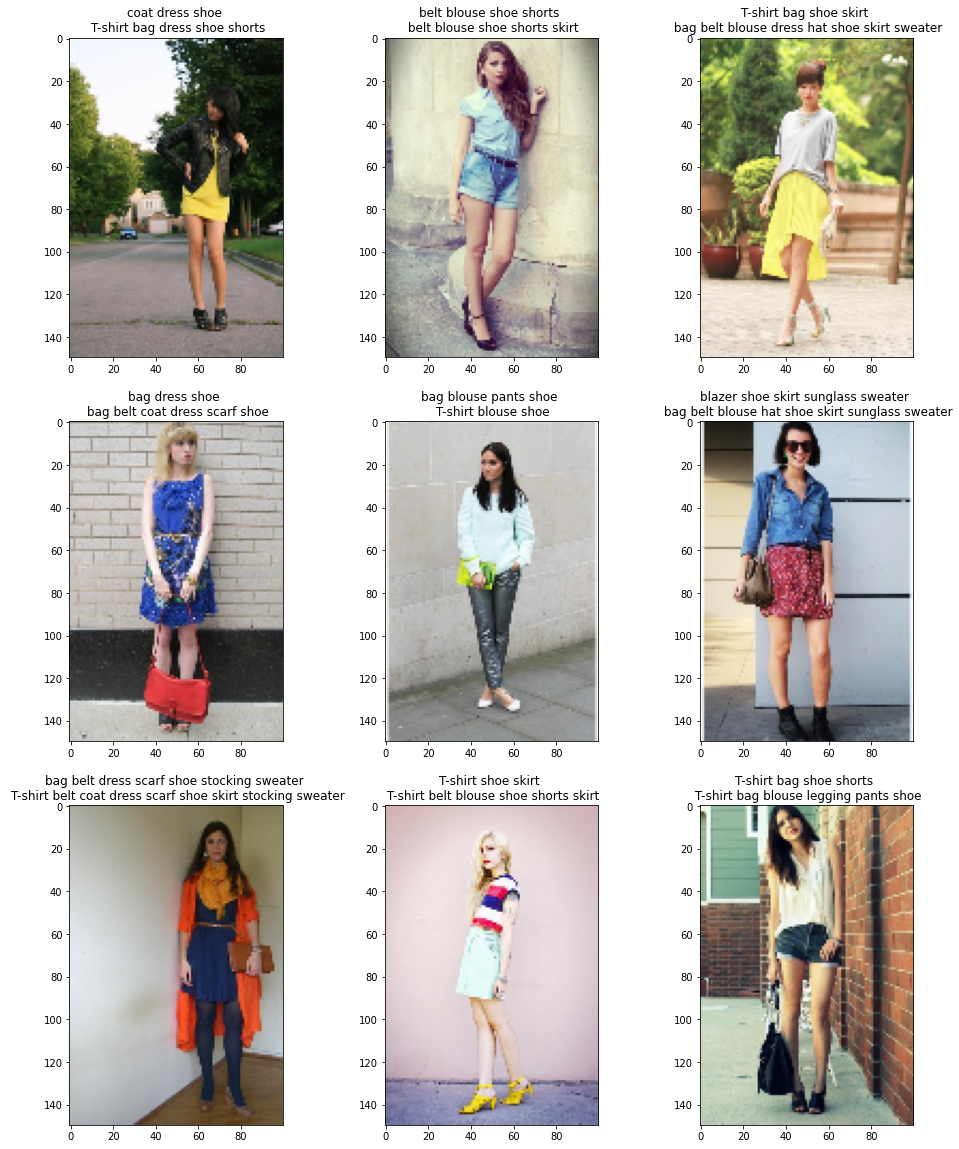

In [361]:
cat_names = np.array(df_label.columns)

th = 0.5
rows = 3
cols = 3
fig, ax = plt.subplots(rows,cols, figsize = (16, 20))
for i in range(rows):
    for j in range(cols):
        ind = 4*i+j
        img = x[ind, :]
        img = img + np.min(img)
        img = img/np.max(img)
        y_pred_one = y_pred[ind,:]
        y_true_one = y_true[ind,:]
        intersect = y_true_one*(y_pred_one>pos_weights)
        wrong_ind = (1-y_true_one)*(y_pred_one>th)
        not_found_ind = y_true_one*(y_pred_one<=th)

        right = cat_names[np.where(intersect>0)[0]]
        wrong = cat_names[np.where(wrong_ind>0)[0]]
        not_found = cat_names[np.where(not_found_ind>0)[0]]

        ax[i, j].imshow(img[:,:,::-1])
        #ax[i, j].set_title("right: {} \n wrong {} \n unfound {}".format(right, wrong, not_found))
        true_labs = cat_names[np.where(y_true_one>0)[0]]
        true_labs = " ".join(true_labs)
        pred_labs = cat_names[np.where(y_pred_one>best_ths)[0]]
        pred_labs = " ".join(pred_labs)
        ax[i, j].set_title("{} \n {}".format(true_labs, pred_labs))

## ROC curves

In [366]:
y_true = False
y_pred = False
for i in range(len(test_gen)):
    x, y_buf_true = test_gen.__getitem__(i)
    y_buf_pred = model.predict(x)
    try:
        y_true = np.concatenate([y_true, y_buf_true], axis = 0)
        y_pred = np.concatenate([y_pred, y_buf_pred], axis = 0)
    except:
        y_true = y_buf_true 
        y_pred = y_buf_pred
print(y_true.shape)

(256, 19)


In [367]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(OUTPUT_CH):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

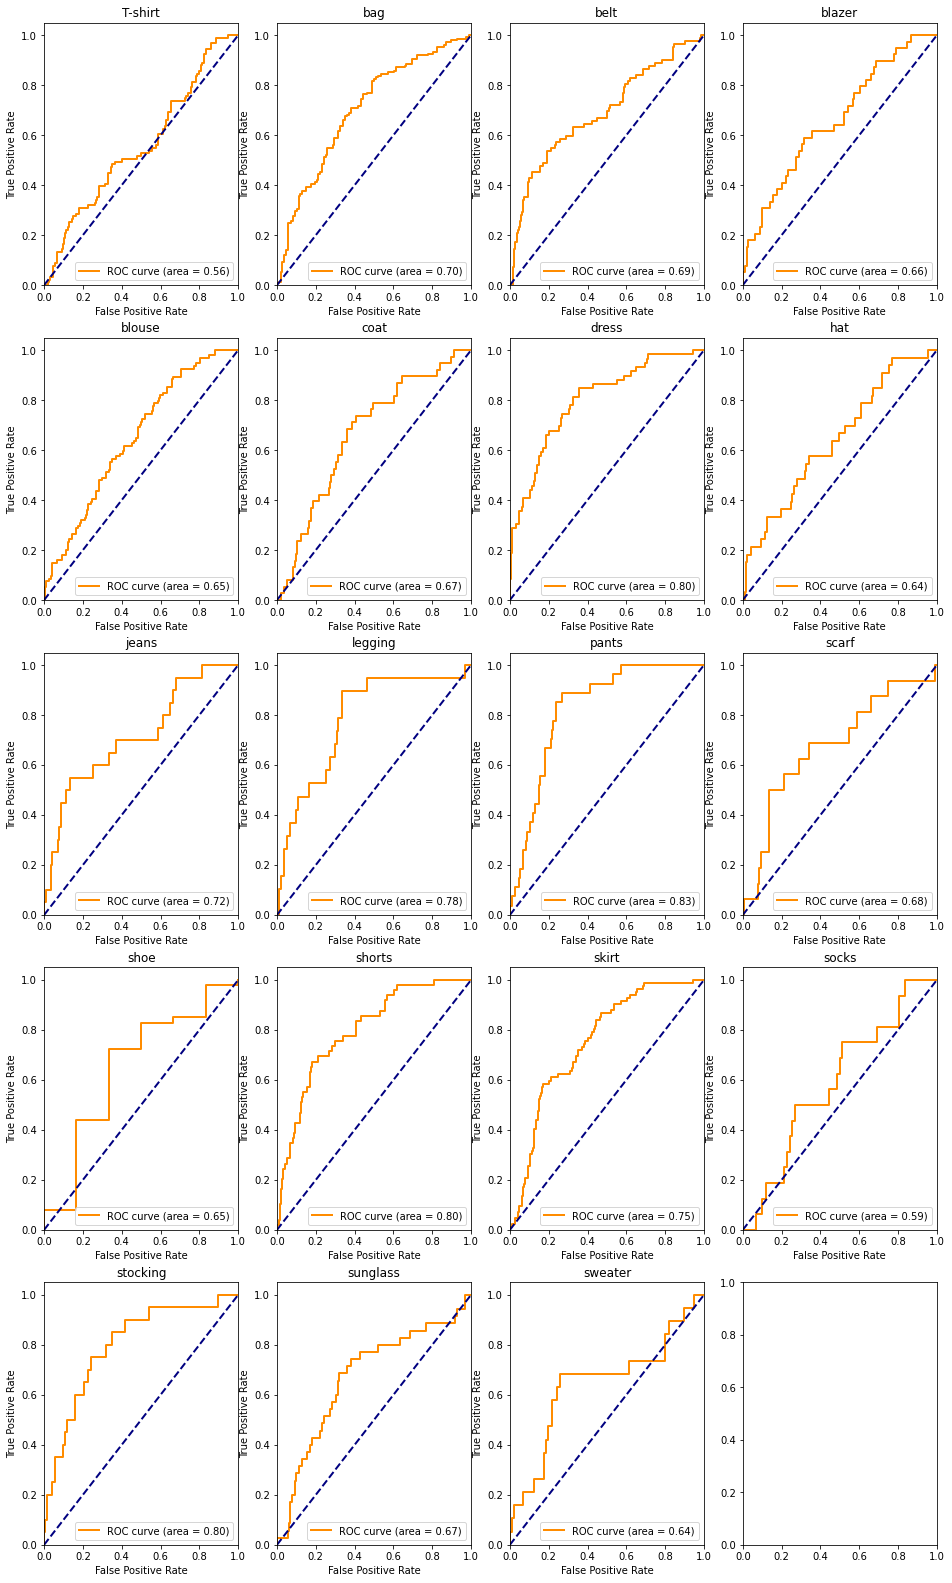

In [372]:
rows = 5
cols = 4

fig, ax = plt.subplots(rows, cols, figsize = (16, 28))
for i in range(rows):
    for j in range(cols):
        ind = i*cols+j
        if ind >= OUTPUT_CH:
            break
        lw = 2
        ax[i,j].plot(fpr[ind], tpr[ind], color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[ind])
        ax[i,j].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        ax[i,j].set_xlim([0.0, 1.0])
        ax[i,j].set_ylim([0.0, 1.05])
        ax[i,j].set_xlabel('False Positive Rate')
        ax[i,j].set_ylabel('True Positive Rate')
        ax[i,j].set_title(cat_names[ind])
        ax[i,j].legend(loc="lower right")


## Get optimal thresholds

In [356]:
y_true = False
y_pred = False
for i in range(10):
    x, y_buf_true = train_gen.__getitem__(i)
    y_buf_pred = model.predict(x)
    try:
        y_true = np.concatenate([y_true, y_buf_true], axis = 0)
        y_pred = np.concatenate([y_pred, y_buf_pred], axis = 0)
    except:
        y_true = y_buf_true 
        y_pred = y_buf_pred
y_true.shape

(640, 19)

In [357]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(OUTPUT_CH):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [358]:
best_ths = np.ones(OUTPUT_CH)*0.5
pr = np.sum(y_true, axis = 0)/y_true.shape[0]
nr = 1 - pr
for i in range(OUTPUT_CH):
    iou = pr[i]*tpr[i]/(pr[i] + fpr[i]*nr[i])
    j = np.argmax(iou)
    best_ths[i] = thresholds[i][j]
best_ths

array([0.40624562, 0.39123744, 0.55082041, 0.54906344, 0.51347578,
       0.51805598, 0.51334977, 0.58771372, 0.80443054, 0.72864342,
       0.63346213, 0.46513137, 0.45225653, 0.69633853, 0.44353905,
       0.58837688, 0.7285409 , 0.56827557, 0.54245281])

In [279]:
import sklearn.metrics
sklearn.metrics.roc_auc_score(y[:,7], y_pred[:,7])

0.7477678571428572

## Some predictions

In [377]:
x, y_true = test_gen.__getitem__(0)
y_pred = model.predict(x)
y_pred = np.array(y_pred)
y_pred.shape

(64, 19)

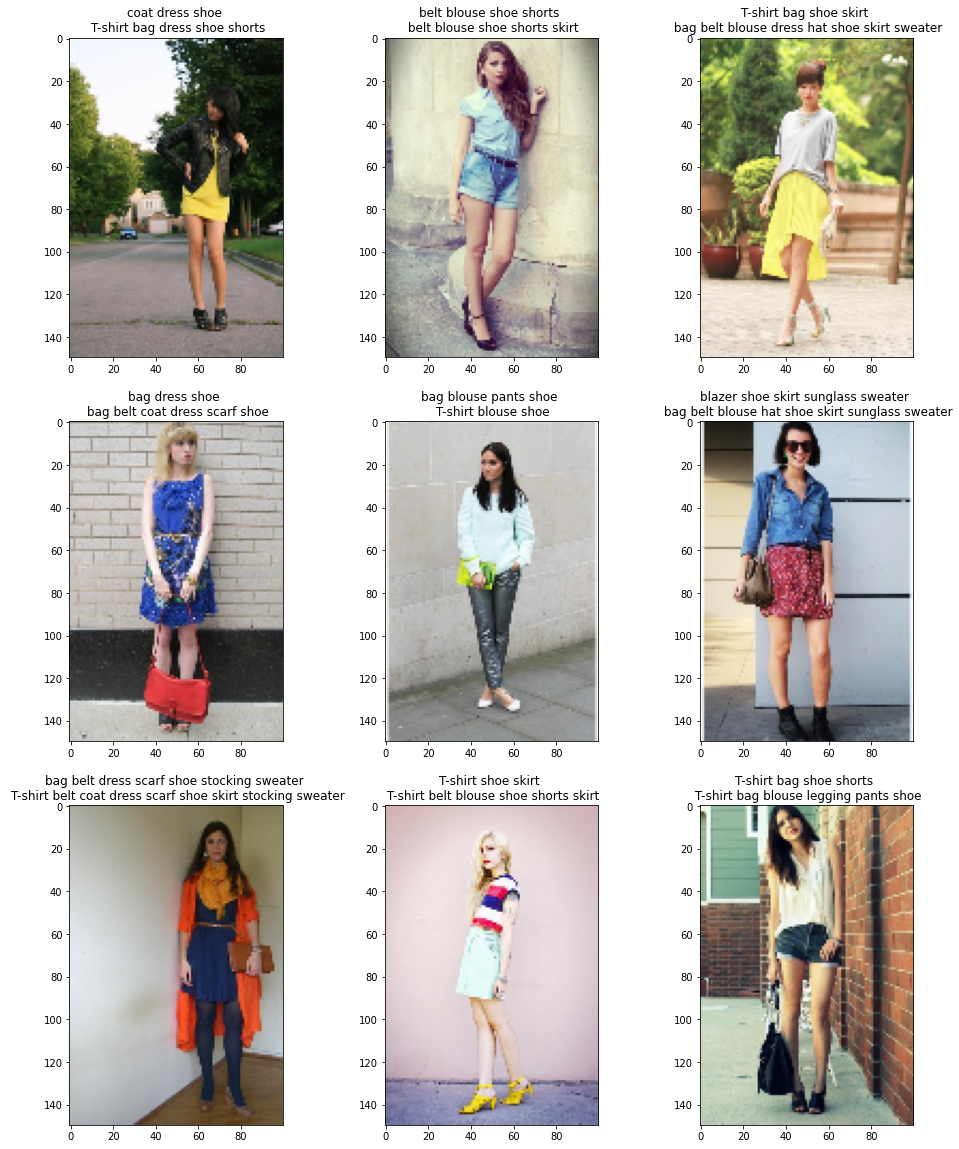

In [378]:
cat_names = np.array(df_label.columns)

th = 0.5
rows = 3
cols = 3
fig, ax = plt.subplots(rows,cols, figsize = (16, 20))
for i in range(rows):
    for j in range(cols):
        ind = 4*i+j
        img = x[ind, :]
        y_pred_one = y_pred[ind,:]
        y_true_one = y_true[ind,:]

        ax[i, j].imshow(img[:,:,::-1])
        #ax[i, j].set_title("right: {} \n wrong {} \n unfound {}".format(right, wrong, not_found))
        true_labs = cat_names[np.where(y_true_one>0)[0]]
        true_labs = " ".join(true_labs)
        pred_labs = cat_names[np.where(y_pred_one>best_ths)[0]]
        pred_labs = " ".join(pred_labs)
        ax[i, j].set_title("{} \n {}".format(true_labs, pred_labs))